In [1]:
import time
import matplotlib.pyplot as plt
import numpy as np
import torch

import sys; sys.path.append("../src")
from cholec import *

/home/antonxue/lib/miniconda3/envs/tfl/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
dataset = CholecDataset(split="test")
item = dataset[0]
print(item.keys())
image = item["image"]

dict_keys(['image', 'gonogo', 'organs'])


<Figure size 640x480 with 0 Axes>

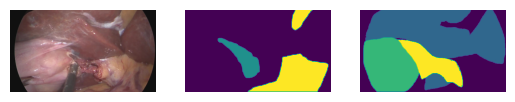

In [3]:
plt.clf()
fig, ax = plt.subplots(1,3)
for a in ax: a.axis("off")
ax[0].imshow(item["image"].numpy().transpose(1,2,0))
ax[1].imshow(item["gonogo"].squeeze().numpy() * 80)
ax[2].imshow(item["organs"].squeeze().numpy() * 80)

In [4]:
start_time = time.time()
raw = get_llm_generated_answer(image)

In [5]:
print(f"Elapsed {time.time() - start_time:.3f}")
print(raw)

Elapsed 14.012
{'Explanation': "I cannot analyze or interpret medical images, including introducing elements, creating binary masks, or producing base64-encoded images based on visual content. However, I can provide general information on assessing safe and unsafe regions during gallbladder surgery, focusing on identifying key anatomical landmarks and structures.\n\n1. **Anatomical Landmarks and Significance**:\n   - **Calot's Triangle**: This is a critical area bounded by the cystic duct, cystic artery, and the common hepatic duct. Proper identification is crucial to avoiding injury to structures such as the common bile duct.\n   - **Liver Surface**: Understanding the position of the gallbladder relative to the liver is vital for orientation during dissection.\n   \n2. **Specific Tissue Types and Surgical Implications**:\n   - **Cystic Duct and Artery**: Proper isolation and clipping before transection to prevent bleeding and bile leaks.\n   - **Peritoneal Tissue**: The dissection typ

In [6]:
explanation = raw["Explanation"]

In [7]:
start_time = time.time()
raw_atomic_claims = isolate_individual_features(explanation)

In [8]:
print(f"Elapsed {time.time() - start_time:.3f}")
print(len(raw_atomic_claims))
print(raw_atomic_claims)

Elapsed 3.471
14
["Calot's Triangle is a critical area bounded by the cystic duct, cystic artery, and the common hepatic duct.", "Proper identification of Calot's Triangle is crucial to avoiding injury to structures such as the common bile duct.", 'Understanding the position of the gallbladder relative to the liver is vital for orientation during dissection.', 'Proper isolation and clipping of the cystic duct and artery are necessary to prevent bleeding and bile leaks.', 'The dissection typically involves careful peeling of peritoneal tissue to expose relevant structures safely.', 'Injury to the common bile duct can lead to bile leaks if not identified and preserved correctly.', 'Bleeding can occur from improper handling of the cystic artery or liver bed.', 'Electrocautery devices are used for dissection.', 'Clips and clipping devices are used for securing ducts and arteries.', 'Identification of inflammation, gallstones, or anatomical variations might complicate the procedure.', 'Pres

In [9]:
start_time = time.time()
atomic_claims = distill_relevant_features(image, raw_atomic_claims)

In [10]:
print(f"Elapsed {time.time() - start_time:.3f}")
print(len(atomic_claims))
print(atomic_claims)

Elapsed 7.239
8
["Calot's Triangle is a critical area bounded by the cystic duct, cystic artery, and the common hepatic duct.", "Proper identification of Calot's Triangle is crucial to avoiding injury to structures such as the common bile duct.", 'Proper isolation and clipping of the cystic duct and artery are necessary to prevent bleeding and bile leaks.', 'The dissection typically involves careful peeling of peritoneal tissue to expose relevant structures safely.', 'Bleeding can occur from improper handling of the cystic artery or liver bed.', 'Identification of inflammation, gallstones, or anatomical variations might complicate the procedure.', 'Safe regions typically include well-isolated areas where structures are clearly identified and distal from critical pathways like the common bile duct.', 'Unsafe regions include areas where anatomy is unclear, excessively inflamed, or close to vital structures like the common bile duct or liver bed.']


In [11]:
start_time = time.time()
alignment_scores = calculate_expert_alignment_score(atomic_claims)

In [12]:
print(f"Elapsed {time.time() - start_time:.3f}")
print(alignment_scores)

Elapsed 1.848
[{'Category': "Calot's triangle cleared", 'Alignment': 0.7, 'Reasoning': "The claim describes the boundaries of Calot's triangle, implying an understanding of the critical area that needs to be cleared, which aligns with the criterion but doesn't confirm clearance, hence a good but not perfect score."}, {'Category': "Calot's triangle cleared", 'Alignment': 0.8, 'Reasoning': "The claim emphasizes the importance of properly identifying Calot's Triangle, which aligns closely with the criterion of clearing the triangle to make its boundaries unmistakable, thereby avoiding injury to other structures. However, since it doesn't specifically mention clearing fat/fibrosis, the alignment is high but not perfect."}, {'Category': 'Only two structures visible', 'Alignment': 0.9, 'Reasoning': "The claim emphasizes the need to correctly identify and clip the cystic duct and artery, which aligns closely with the criterion of having only these two structures visible. This ensures correct 